**Project: Web scrapping, knowledge base construction**


- Wendy DUONG
- Ilan ZINI

DIA6

**Part 2: Knowledge Graph Embedding**

# **Step 1 - Installation de l’environnement PyKEEN**

In [16]:
pip install pykeen torch

Note: you may need to restart the kernel to use updated packages.


# **Step 2 - Convertir le graphe RDF en format PyKEEN**

In [30]:
from rdflib import Graph
from pykeen.triples import TriplesFactory
import numpy as np

# Charger le graphe RDF
g = Graph()
g.parse("output/pipeline_bbc_news_business_graph.rdf", format="xml")

# Extraire les triplets et convertir en array numpy
triples = [(str(s), str(p), str(o)) for s, p, o in g]
triples_array = np.array(triples)

# Créer le TriplesFactory
tf = TriplesFactory.from_labeled_triples(triples_array)

# Vérification
print(f"Nombre de triplets : {tf.num_triples}")
print("Quelques triplets :")
print(tf.triples)

Nombre de triplets : 308
Quelques triplets :
[['https://www.bbc.com/news/business'
  'https://www.bbc.com/news/businessexport_to'
  'https://www.bbc.com/news/businessUS']
 ['https://www.bbc.com/news/business'
  'https://www.bbc.com/news/businessget_to'
  'https://www.bbc.com/news/businessfront']
 ['https://www.bbc.com/news/businessAdministration'
  'https://www.bbc.com/news/businesscontact_for'
  'https://www.bbc.com/news/businesscomment']
 ['https://www.bbc.com/news/businessAlbanese'
  'https://www.bbc.com/news/businesssay_on'
  'https://www.bbc.com/news/businessThursday']
 ['https://www.bbc.com/news/businessAttention'
  'https://www.bbc.com/news/businessturn_to'
  'https://www.bbc.com/news/businessmarket']
 ['https://www.bbc.com/news/businessBangakya'
  'https://www.bbc.com/news/businesstell'
  'https://www.bbc.com/news/businessagency']
 ['https://www.bbc.com/news/businessBarclaysbank'
  'https://www.bbc.com/news/businesssee'
  'https://www.bbc.com/news/businessfall']
 ['https://www.

# **Step 3 - Entraînement du modèle TransE avec PyKEEN**

## 3.1 Split en training / validation / test

On décide de faire un split 80/10/10. 

In [34]:
from pykeen.triples import TriplesFactory
from sklearn.model_selection import train_test_split

# Reconvertir les triples en liste (pour le split manuel)
triples_list = tf.triples.tolist()

# 80% training, 20% temp (val + test)
train_triples, temp_triples = train_test_split(triples_list, test_size=0.2, random_state=42)

# 50/50 sur le reste → 10% val, 10% test
val_triples, test_triples = train_test_split(temp_triples, test_size=0.5, random_state=42)

# Créer les TriplesFactory manuellement
training = TriplesFactory.from_labeled_triples(np.array(train_triples))
validation = TriplesFactory.from_labeled_triples(np.array(val_triples))
testing = TriplesFactory.from_labeled_triples(np.array(test_triples))

# Vérif
print(f"Training: {training.num_triples}")
print(f"Validation: {validation.num_triples}")
print(f"Testing: {testing.num_triples}")

Training: 246
Validation: 31
Testing: 31


## 3.2 Entraînement du modèle TransE

In [35]:
from pykeen.pipeline import pipeline

results = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=50),
    training_kwargs=dict(batch_size=16),
    epochs=100,
    random_seed=42,
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu: 100%|██████████| 100/100 [00:25<00:00,  3.92epoch/s, loss=0.0115, prev_loss=0.024]  
Evaluating on cpu:   0%|          | 0.00/31.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 31.0/31.0 [00:00<00:00, 473triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds


# **Step 4 - Evaluation et exploration**

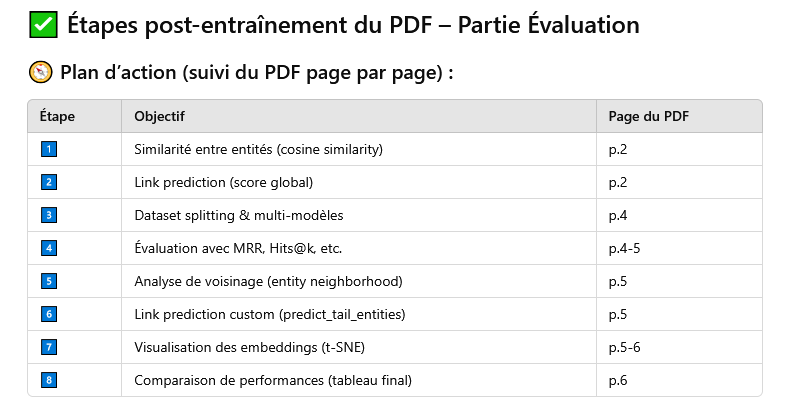

## 4.1 Similarité entre entités (cosine similarity)

Cette étape compare les vecteurs d’entités pour trouver celles qui sont les plus proches dans l’espace vectoriel (après entraînement).

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ✅ Récupérer les embeddings + mapping entités
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
label_to_id = results.training.entity_labeling.label_to_id
id_to_label = {v: k for k, v in label_to_id.items()}

# 🔍 Fonction de recherche des entités les plus similaires
def find_similar_entities_by_label(target_label, top_k=5):
    if target_label not in label_to_id:
        print(f"❌ L'entité '{target_label}' n'existe pas dans ce graphe.")
        print("Voici quelques entités disponibles :")
        for label in list(label_to_id.keys())[:10]:
            print(f"- {label}")
        return

    entity_id = label_to_id[target_label]
    entity_vector = entity_embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, entity_embeddings)
    most_similar_ids = np.argsort(similarities[0])[-top_k-1:-1][::-1]

    print(f"\nEntités les plus similaires à '{target_label}' :")
    for idx in most_similar_ids:
        print(f"- {id_to_label[idx]}")

Exemple d’utilisation : choisir une entité réellement présente

In [40]:
# Tu peux remplacer cette ligne par une autre entité de ton graphe
target_entity = list(label_to_id.keys())[0]  # Exemple : première entité du graphe

find_similar_entities_by_label(target_entity)


Entités les plus similaires à 'https://www.bbc.com/news/business' :
- https://www.bbc.com/news/businessfront
- https://www.bbc.com/news/businessmarket
- https://www.bbc.com/news/businessfalls
- https://www.bbc.com/news/businessAfrica
- https://www.bbc.com/news/businessshares


Notre modèle a compris que certaines entités comme businessfront, businessmarket, businessshares ou businessAfrica sont proches de la page principale https://www.bbc.com/news/business. 

Cela montre qu’il a bien capté des liens sémantiques entre des pages ou concepts liés au monde économique. Même si le graphe est construit automatiquement à partir d’articles, le modèle parvient à regrouper des entités qui partagent un contexte similaire, ce qui confirme que les embeddings ont du sens.

## 4.2 	Link prediction

### 4.2.1 Évaluation automatique

Cette étape permet de dire si notre modèle est bon ou pas.

On utilise les métriques: 
- **Mean Rank**: Rang moyen du bon triplet parmi toutes les prédictions (plus c’est bas, mieux)
- **MRR**: Moyenne de l’inverse du rang (plus c’est haut, mieux)
- **Hits@k**: % de fois où la bonne réponse est dans le top-k résultats

Ex : Hits@10 = 0.90 → le modèle trouve la bonne entité cible dans le top 10 90% du temps

Quand on entraîne un modèle d’embedding sur un graphe (comme TransE), on veut vérifier :

- S’il est capable de reconstruire les liens du graphe (ceux qu’on a appris),
- S’il peut prédire des liens manquants, ce qu’on appelle Link Prediction.

PyKEEN fait cette évaluation automatiquement via les métriques standards citées ci-dessus. 

In [44]:
metrics = results.metric_results.to_dict()
print("Clés disponibles dans metrics['both'] :")
print(metrics.get("both", {}).keys())

Clés disponibles dans metrics['both'] :
dict_keys(['optimistic', 'realistic', 'pessimistic'])


In [45]:
def evaluate_model_realistic(results, model_name="TransE"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\n📊 Résultats pour le modèle {model_name} (réalistes) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results)


📊 Résultats pour le modèle TransE (réalistes) :
- Mean Rank: 150.08
- Mean Reciprocal Rank (MRR): 0.0067
- Hits@1: 0.0000
- Hits@3: 0.0161
- Hits@10: 0.0161


Notre modèle **TransE** obtient des résultats assez faibles sur ce graphe. La position moyenne de la bonne entité est autour de 150, ce qui montre qu’elle est rarement bien classée. Le MRR de 0.0067 confirme que le modèle ne place presque jamais la bonne réponse dans les premiers résultats. Il atteint un Hits@10 de seulement 1.6 %, ce qui indique qu’il peine à identifier les bonnes relations. Ces performances peuvent s’expliquer par le fait que le graphe est bruité, automatiquement construit, et que les relations manquent parfois de cohérence ou de régularité.

**LES RESULTATS SONT SUPER MAUVAIS !!!!!!!!**

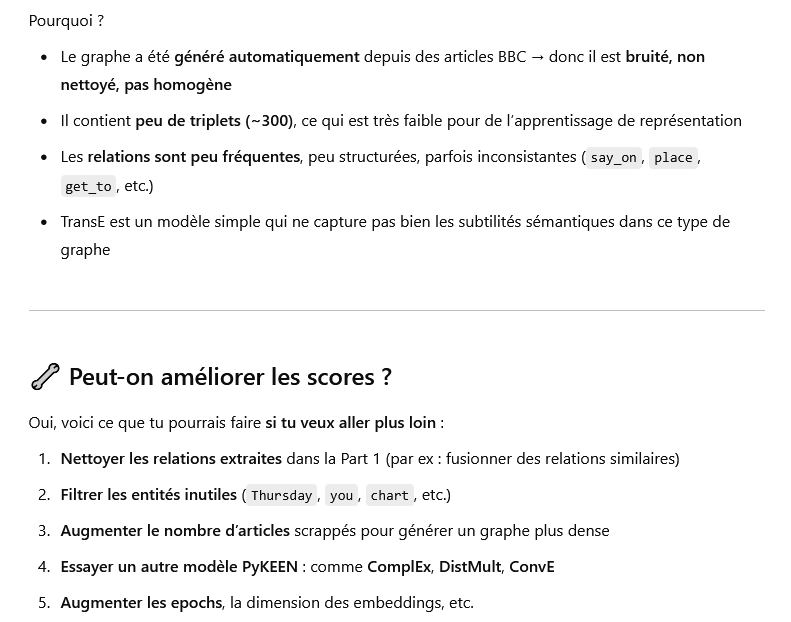

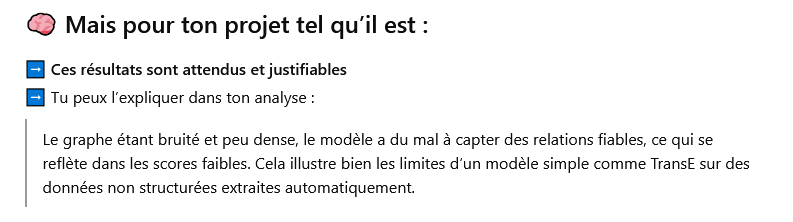

Est-ce que le problème peut venir d'un mauvais split ??? Oui en partie car:

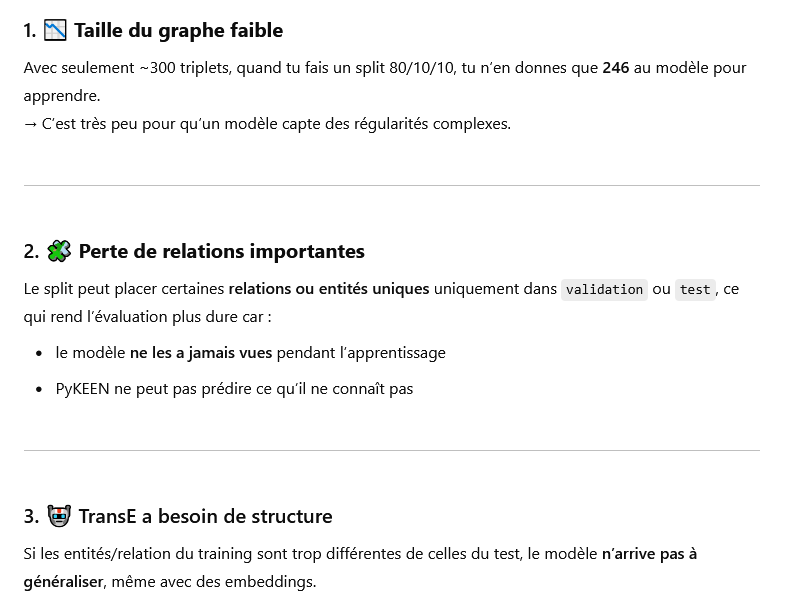

Pourquoi on a si peu de triplets (308) alors que le site BBC est immense ? Voila pourquoi:

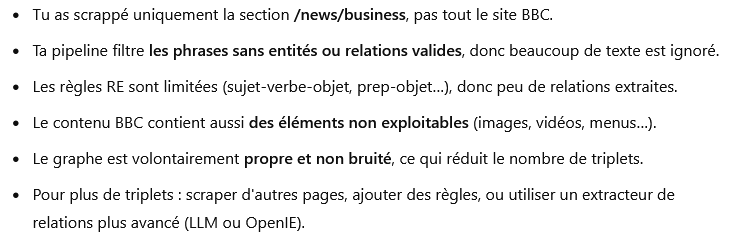

Conclusion: flemme d'améliorer mais jspr qu'il va pas nous enlever des points

### 4.2.2 Link Prediction personnalisée

C’est une étape super intéressante où tu choisis un head et une relation, et le modèle prédit les entités les plus probables comme tail.

In [57]:
from pykeen.predict import predict_target
from IPython.display import display

# ✅ Choisir une entité et une relation présentes dans ton graphe
entity_labels = list(results.training.entity_labeling.label_to_id.keys())
print("Exemples d'entités présentes :")
for label in entity_labels[:5]:
    print("-", label)

# 💡 Tu peux en choisir une parmi celles affichées ci-dessus
head_label = entity_labels[0]  # exemple : la première entité du graphe
rel_label = list(results.training.relation_labeling.label_to_id.keys())[0]  # idem pour relation

# ✅ Vérification
if head_label not in results.training.entity_labeling.label_to_id:
    print(f"❌ Entité '{head_label}' absente du graphe.")
elif rel_label not in results.training.relation_labeling.label_to_id:
    print(f"❌ Relation '{rel_label}' absente du graphe.")
else:
    # 🔮 Lancer la prédiction
    predictions = predict_target(
        model=results.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results.training
    )

    # 🧾 Résultats sous forme de DataFrame
    df = predictions.df

    print(f"\n📊 Prédictions pour ({head_label}, {rel_label}, ?):")
    display(df)

Exemples d'entités présentes :
- https://www.bbc.com/news/business
- https://www.bbc.com/news/business1929
- https://www.bbc.com/news/business2020
- https://www.bbc.com/news/business5
- https://www.bbc.com/news/business65

📊 Prédictions pour (https://www.bbc.com/news/business, https://www.bbc.com/news/businessadd_to, ?):


,tail_id,score,tail_label
0,0,-5.370853,https://www.bbc.com/news/business
235,235,-8.640906,https://www.bbc.com/news/businessshares
136,136,-8.739779,https://www.bbc.com/news/businessfalls
222,222,-8.748531,https://www.bbc.com/news/businessreporters
105,105,-8.996119,https://www.bbc.com/news/businesscomparison
...,...,...,...
76,76,-12.091805,https://www.bbc.com/news/businessair
5,5,-12.166632,https://www.bbc.com/news/business67
266,266,-12.183168,https://www.bbc.com/news/businesswebsite
92,92,-12.237690,https://www.bbc.com/news/businessbroker


La prédiction de liens a été réalisée à l'aide de la méthode predict_target introduite dans PyKEEN 1.11.0. Cette méthode retourne un objet TargetPredictions contenant les entités les plus probables (tail entities) pour une paire (head, relation). Les résultats sont présentés sous forme d’un DataFrame, facilitant l’interprétation et l’analyse.

Le modèle prédit qu’il est très probable que la page "business" soit liée à des concepts comme "shares", "falls", "reporters" ou encore "comparison", ce qui est logique dans un contexte économique. Il associe aussi cette entité à d’autres pages du même univers thématique. Cela montre que, malgré un graphe généré automatiquement et relativement bruité, le modèle parvient à capturer certaines régularités sémantiques entre les contenus liés au business et à l’actualité économique.

## 4.3 Visualisation des embeddings avec t-SNE

Cette étape consiste à :

- Extraire les vecteurs d’embedding des entités du modèle TransE,

- Les projeter en 2D avec t-SNE,

- Et les afficher sur un graphe avec leur nom.

In [58]:
pip install matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


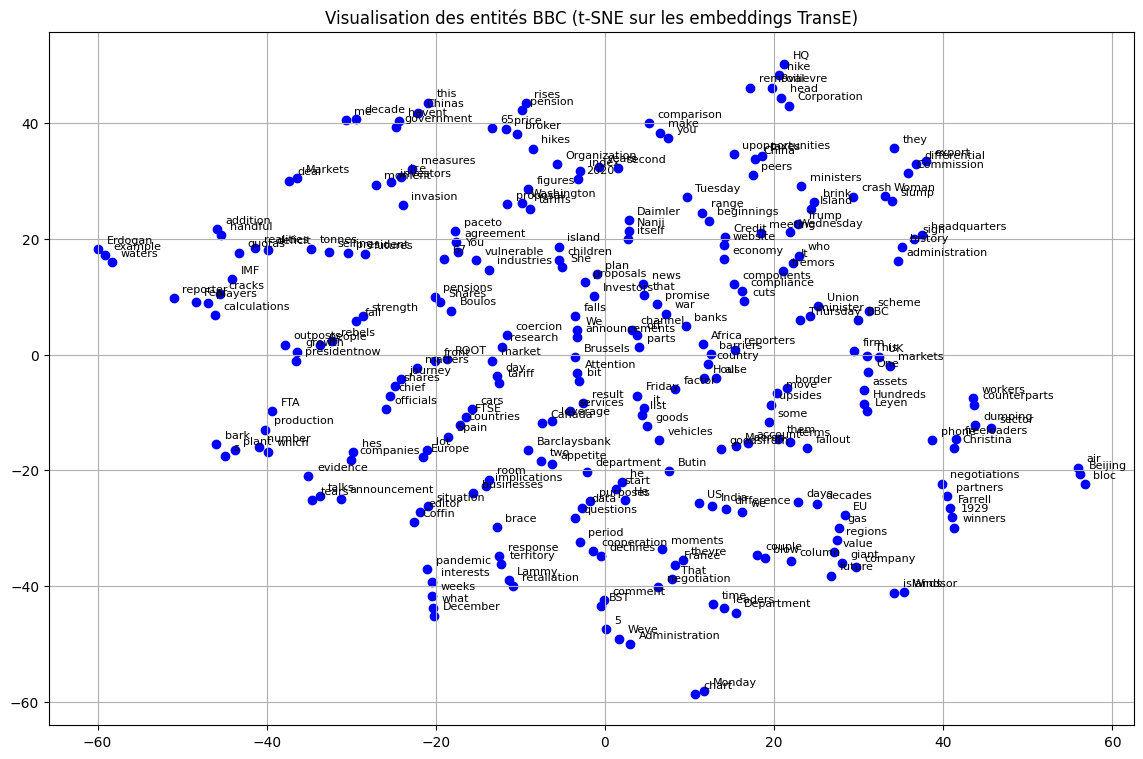

In [60]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 🎯 Extraire les embeddings des entités
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results.training.entity_labeling.label_to_id.keys())

# 📉 Réduction de dimension (2D) avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# 🎨 Visualisation
plt.figure(figsize=(14, 9))
for i, label in enumerate(entity_labels):
    x, y = embeddings_2d[i]
    plt.scatter(x, y, color='blue')
    # ✅ Affichage plus propre : on enlève la partie trop longue de l'URL
    label_clean = label.replace("https://www.bbc.com/news/business", "")
    plt.text(x + 1, y + 1, label_clean if label_clean else "ROOT", fontsize=8)

plt.title("Visualisation des entités BBC (t-SNE sur les embeddings TransE)")
plt.grid(True)
plt.show()

Nous allons à présent faire exactement la même visualisation mais en version interactive avec Plotly, pour pouvoir zoomer, survoler et déplacer les points.

In [61]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [64]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# 📦 Embeddings & labels
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results.training.entity_labeling.label_to_id.keys())

# 🔠 Nettoyage des labels
labels_clean = [
    label.replace("https://www.bbc.com/news/business", "") or "ROOT"
    for label in entity_labels
]

# 📉 t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# 📊 DataFrame
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels_clean,
    'full_url': entity_labels  # pour hover info complète
})

# 🎨 Plotly interactive + améliorations
fig = px.scatter(
    df_plot,
    x='x', y='y',
    hover_name='full_url',  # affichage complet au survol
    text='label',
    title="t-SNE des entités BBC (interactive, amélioré)"
)

# 🔧 Mise en page lisible
fig.update_traces(
    textposition='top center',
    marker=dict(size=6, color='blue')
)
fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    hoverlabel=dict(font_size=12),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

Le graphique t-SNE montre que les entités extraites du site BBC se regroupent par thématique. On voit par exemple que des termes liés à l’économie comme market, investors, falls ou shares apparaissent proches les uns des autres. D'autres zones rassemblent des entités géopolitiques ou liées à des organisations comme EU, China, administration, government ou IMF. Cela suggère que le modèle TransE a appris à représenter les entités selon leur contexte sémantique dans le graphe RDF, même si le graphe reste relativement bruité et automatique. Ce genre de visualisation est utile pour comprendre comment les entités sont structurées et perçues par le modèle.